#### Scrape the Location Counts
Use the beautifulsoup library to scrape the data (from the link above) on state names and corresponding number of store locations, for the following chains:
Starbucks

Dunkin’ Donuts

In [161]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np 
import requests

In [163]:
starraw = requests.get("https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state")
dunkraw = requests.get("https://worldpopulationreview.com/state-rankings/dunkin-donuts-by-state")
soup_star = BeautifulSoup(starraw.content, "html.parser")
soup_dunk = BeautifulSoup(dunkraw.content, "html.parser")

In [164]:
len(soup_star.find_all("table"))

1

In [165]:
#check for tables, specifically wpr-table class 
df_test = pd.read_html("https://worldpopulationreview.com/state-rankings/starbucks-stores-by-state")
#df_test
#only 1 wpr-table, but also only one table, so no real need to specify

Parse, merge and tidy your data. Think carefully about what the tidy version of this dataset is with multiple years represented on the website.

#### Tidy Starbucks <br>
Tidy:variables are in columns, observations are in rows, and values are in cells. Years are observations, therefore we have to alter the web format to melt into a "year" column

In [166]:
# tr: state is th, years are td
# Starbucks scrape 

def extract_soup_starbucks(soup, brand):
    table = soup.find("table")

    # Initialize lists to store rows
    rows = []

    # Using table headers to get states, based on how the html is formatted for this table 
    #Table header[4:] is based on how many table headers before the first row of data
    states_list = [th.get_text(strip=True) for th in table.find_all("th")[4:]]
    print(f"States list: {states_list}")

    # Iterate through each row in the table, use table data to get relevant values (store count)
    for i, tr in enumerate(table.find_all("tr")[1:]):
        cells = tr.find_all("td")
        #referenced from chatGPT, This conditional statement checks two conditions that determine whether to skip the current iteration of the loop.
        # index should be same length as states. len cells should be 3 for 3 years
        if len(cells) < 3 or i >= len(states_list):
            continue
        
        state = states_list[i]
        # order of cell index is not related to year order, because of the website's poor formatting
        # <a> is the anchor tag, referenced from stack overflow. if there is an anchor tag, loop retrieves text from the anchor tag, otherwise collects from cell itself
        year21 = cells[0].find("a").get_text(strip=True) if cells[0].find("a") else cells[0].get_text(strip=True)
        year23 = cells[1].find("a").get_text(strip=True) if cells[1].find("a") else cells[1].get_text(strip=True)
        year24 = cells[2].find("a").get_text(strip=True) if cells[2].find("a") else cells[2].get_text(strip=True)

       
        rows.append({
            "State": state,
            "2021": year21,
            "2023": year23,
            "2024": year24,
            "Brand": brand
        })

    
    df = pd.DataFrame(rows)

    # Melt the DataFrame to tidy it
    tidy_df = df.melt(id_vars=["State", "Brand"], var_name="year", value_name="count")
    
    return tidy_df

In [167]:
tidy_star = extract_soup_starbucks(soup_star, "Starbucks")

States list: ['California', 'Texas', 'Florida', 'Washington', 'New York', 'Illinois', 'Arizona', 'Colorado', 'Ohio', 'Virginia', 'Oregon', 'Pennsylvania', 'North Carolina', 'Georgia', 'Michigan', 'Massachusetts', 'New Jersey', 'Maryland', 'Nevada', 'Indiana', 'Missouri', 'Minnesota', 'Tennessee', 'Kentucky', 'Wisconsin', 'South Carolina', 'Connecticut', 'Utah', 'Hawaii', 'Kansas', 'District of Columbia', 'Iowa', 'Alabama', 'Louisiana', 'Oklahoma', 'New Mexico', 'Idaho', 'Nebraska', 'Arkansas', 'Alaska', 'Mississippi', 'Montana', 'Maine', 'New Hampshire', 'Rhode Island', 'Delaware', 'South Dakota', 'West Virginia', 'Wyoming', 'North Dakota', 'Vermont']


#### Tidy Dunkin 

In [168]:
#repeating the same steps as above, with small changes due to the table's layout. Years is only 2024 and 2023. 
def extract_soup_dunkin(soup, brand):
    table = soup.find("table")

    rows = []

    states_list = [th.get_text(strip=True) for th in table.find_all("th")[4:]]
    print(f"States list: {states_list}")

    for i, tr in enumerate(table.find_all("tr")[1:]):
        cells = tr.find_all("td")
        
        if len(cells) < 2 or i >= len(states_list):
            continue
        
        state = states_list[i]

        year24 = cells[0].find("a").get_text(strip=True) if cells[0].find("a") else cells[0].get_text(strip=True)
        year23 = cells[1].find("a").get_text(strip=True) if cells[1].find("a") else cells[1].get_text(strip=True)

        rows.append({
            "State": state,
            "2023": year23,
            "2024": year24,
            "Brand": brand
        })

    df = pd.DataFrame(rows)

    tidy_df = df.melt(id_vars=["State", "Brand"], var_name="year", value_name="count")
    
    return tidy_df

In [169]:
tidy_dunk = extract_soup_dunkin(soup_dunk, "Dunkin")
tidy_dunk

States list: ['Massachusetts', 'Florida', 'New Jersey', 'Illinois', 'Pennsylvania', 'Connecticut', 'Maryland', 'Georgia', 'Ohio', 'Virginia', 'Texas', 'North Carolina', 'New Hampshire', 'Maine', 'Rhode Island', 'California', 'Tennessee', 'Indiana', 'South Carolina', 'Michigan', 'Arizona', 'Wisconsin', 'Alabama', 'Delaware', 'Missouri', 'Kentucky', 'Vermont', 'Colorado', 'Nevada', 'Minnesota', 'Iowa', 'West Virginia', 'Kansas', 'Nebraska', 'Oklahoma', 'District of Columbia', 'New Mexico', 'Louisiana', 'Arkansas', 'Mississippi', 'Hawaii', 'Utah', 'Wyoming', 'Alaska', 'Idaho', 'Montana', 'North Dakota', 'Oregon', 'South Dakota', 'Washington']


,State,Brand,year,count
0,Massachusetts,Dunkin,2023,"1,414"
1,Florida,Dunkin,2023,"1,068"
2,New Jersey,Dunkin,2023,883
3,Illinois,Dunkin,2023,866
4,Pennsylvania,Dunkin,2023,692
...,...,...,...,...
95,Montana,Dunkin,2024,0
96,North Dakota,Dunkin,2024,0
97,Oregon,Dunkin,2024,0
98,South Dakota,Dunkin,2024,0


#### Merge

In [170]:
coffee = pd.merge(tidy_star, tidy_dunk, on=['State', 'year'], how='outer', suffixes=('_starbucks', '_dunkin'))
coffee


,State,Brand_starbucks,year,count_starbucks,Brand_dunkin,count_dunkin
0,Alabama,Starbucks,2021,85,NaN,NaN
1,Alabama,Starbucks,2023,99,Dunkin,83
2,Alabama,Starbucks,2024,,Dunkin,100
3,Alaska,Starbucks,2021,49,NaN,NaN
4,Alaska,Starbucks,2023,49,Dunkin,1
...,...,...,...,...,...,...
148,Wisconsin,Starbucks,2023,176,Dunkin,102
149,Wisconsin,Starbucks,2024,,Dunkin,110
150,Wyoming,Starbucks,2021,23,NaN,NaN
151,Wyoming,Starbucks,2023,26,Dunkin,1


In [171]:
#tidy the brand column
tidy_coffee = coffee.melt(
    id_vars=['State', 'year'],
    value_vars=['count_starbucks', 'count_dunkin'],
    var_name='Brand',
    value_name='count' )
tidy_coffee['Brand'] = tidy_coffee['Brand'].str.replace('count_', '')
tidy_coffee = tidy_coffee.fillna("")
tidy_coffee

,State,year,Brand,count
0,Alabama,2021,starbucks,85
1,Alabama,2023,starbucks,99
2,Alabama,2024,starbucks,
3,Alaska,2021,starbucks,49
4,Alaska,2023,starbucks,49
...,...,...,...,...
301,Wisconsin,2023,dunkin,102
302,Wisconsin,2024,dunkin,110
303,Wyoming,2021,dunkin,
304,Wyoming,2023,dunkin,1


#### Supplemental Data
4. Scrape the state names and populations from this wikipedia page. Merge these data with your coffee dataset.

In [172]:
wikiraw = requests.get("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")
soup_wiki = BeautifulSoup(wikiraw.content, "html.parser")

In [173]:
len(soup_wiki.find_all("table"))

1

#### Scrape wiki for population and state names

In [174]:
table = soup_wiki.find("table")

wiki_data = []
for row in table.find_all("tr")[1:]:
    cells = row.find_all("td")
    if len(cells) > 1:
        state = cells[2].get_text(strip = True)
        population = cells[3].get_text(strip = True).replace(',', '')
        wiki_data.append({"State": state, "Population": int(population)})

pop_df = pd.DataFrame(wiki_data)
#pop_df

#### Merge onto Coffee

In [175]:
coffee_wiki =  pd.merge(tidy_coffee, pop_df, on = "State", how = 'left')
coffee_wiki.head()

,State,year,Brand,count,Population
0,Alabama,2021,starbucks,85,5024279
1,Alabama,2023,starbucks,99,5024279
2,Alabama,2024,starbucks,,5024279
3,Alaska,2021,starbucks,49,733391
4,Alaska,2023,starbucks,49,733391


5. Find the revenue, stock price, or your financial metric of choice for each of the companies listed above (if you can find a website to scrape these from that’s great!…but it’s okay if you manually enter these). Merge these values into your big dataset. Note: these values may be repeated for each state.

In [176]:
# Total Revenue (Manual)

rev = pd.read_csv("/Users/owenk/OneDrive/Documents/GitHub/GSB_544_ML/Lab 4/Revenue.csv")
rev.head()

,Revenue (B),Brand,year
0,1.456,dunkin,2023
1,1.310,dunkin,2024
2,36.680,starbucks,2023
3,36.200,starbucks,2024
4,29.061,starbucks,2021


In [178]:
# print('Brand' in coffee_wiki.columns)  # Should return True
# print('Brand' in rev.columns)  # Should return True

In [177]:
#merge
coffee_wiki['year'] = coffee_wiki['year'].astype(int)
rev['year'] = rev['year'].astype(int)
coffee_rev = pd.merge(coffee_wiki, rev, on=["Brand", "year"], how="left")
coffee_rev = coffee_rev.fillna("")
coffee_rev.head()

,State,year,Brand,count,Population,Revenue (B)
0,Alabama,2021,starbucks,85,5024279,29.061
1,Alabama,2023,starbucks,99,5024279,36.68
2,Alabama,2024,starbucks,,5024279,36.2
3,Alaska,2021,starbucks,49,733391,29.061
4,Alaska,2023,starbucks,49,733391,36.68


6. Create a region variable in your dataset according to the scheme on this wikipedia page: Northeast, Midwest, South, West. You do not need to scrape this information.

In [179]:
region = {
    "Northeast": {
        "New England": ["Maine", "New Hampshire", "Vermont", "Massachusetts", "Rhode Island", "Connecticut"],
        "Mid-Atlantic": ["New York", "New Jersey", "Pennsylvania"]
    },
    "Midwest": {
        "East North Central": ["Ohio", "Indiana", "Illinois", "Michigan", "Wisconsin"],
        "West North Central": ["Minnesota", "Iowa", "Missouri", "North Dakota", "South Dakota", "Nebraska", "Kansas"]
    },
    "South": {
        "South Atlantic": ["Delaware", "Maryland", "Virginia", "West Virginia", "North Carolina", "South Carolina", "Georgia", "Florida"],
        "East South Central": ["Kentucky", "Tennessee", "Mississippi", "Alabama"],
        "West South Central": ["Arkansas", "Louisiana", "Oklahoma", "Texas"]
    },
    "West": {
        "Mountain": ["Montana", "Idaho", "Wyoming", "Colorado", "New Mexico", "Arizona", "Utah", "Nevada"],
        "Pacific": ["Washington", "Oregon", "California", "Alaska", "Hawaii"]
    }
}

#flatten
region_map = {state: region for region, divisions in region.items() for division, states in divisions.items() for state in states}


In [180]:
def get_region(state):
    return region_map.get(state)

coffee_rev["Region"] = coffee_rev["State"].apply(get_region)
coffee_rev.head()

,State,year,Brand,count,Population,Revenue (B),Region
0,Alabama,2021,starbucks,85,5024279,29.061,South
1,Alabama,2023,starbucks,99,5024279,36.68,South
2,Alabama,2024,starbucks,,5024279,36.2,South
3,Alaska,2021,starbucks,49,733391,29.061,West
4,Alaska,2023,starbucks,49,733391,36.68,West


#### 7. Assess and comment on the prevalence of each chain.

Prevalence by Region and State 
Starbucks and Dunkin Donuts cater to different geographical areas in the US. Based on the first plot, Starbucks has a much greater prescence in the Western Regions, as well as the South, while Dunkin Donuts has a greater number of stores in the East, and Northeast. This is also supported by the second plot, which shows the top 5 staets for Dunkin and Starbucks. The top 5 Dunkin states are all in the New England area, besides Illinois. In contrast, The top 5 starbucks states are in the west and south, with the exception of New York.
On a regional level, the Northeast is often dominated by Dunkin', whereas Starbucks is more widespread in the West and Pacific regions. This geographic distinction reflects broader cultural preferences and market strategies that appeal to local consumers.



In [181]:
from plotnine import *

In [182]:
coffee_rev['count'] = pd.to_numeric(coffee_rev['count'], errors='coerce')
coffee_rev['Region'] = coffee_rev['Region'].dropna()

c:\Users\owenk\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_bar : Removed 106 rows containing missing values.


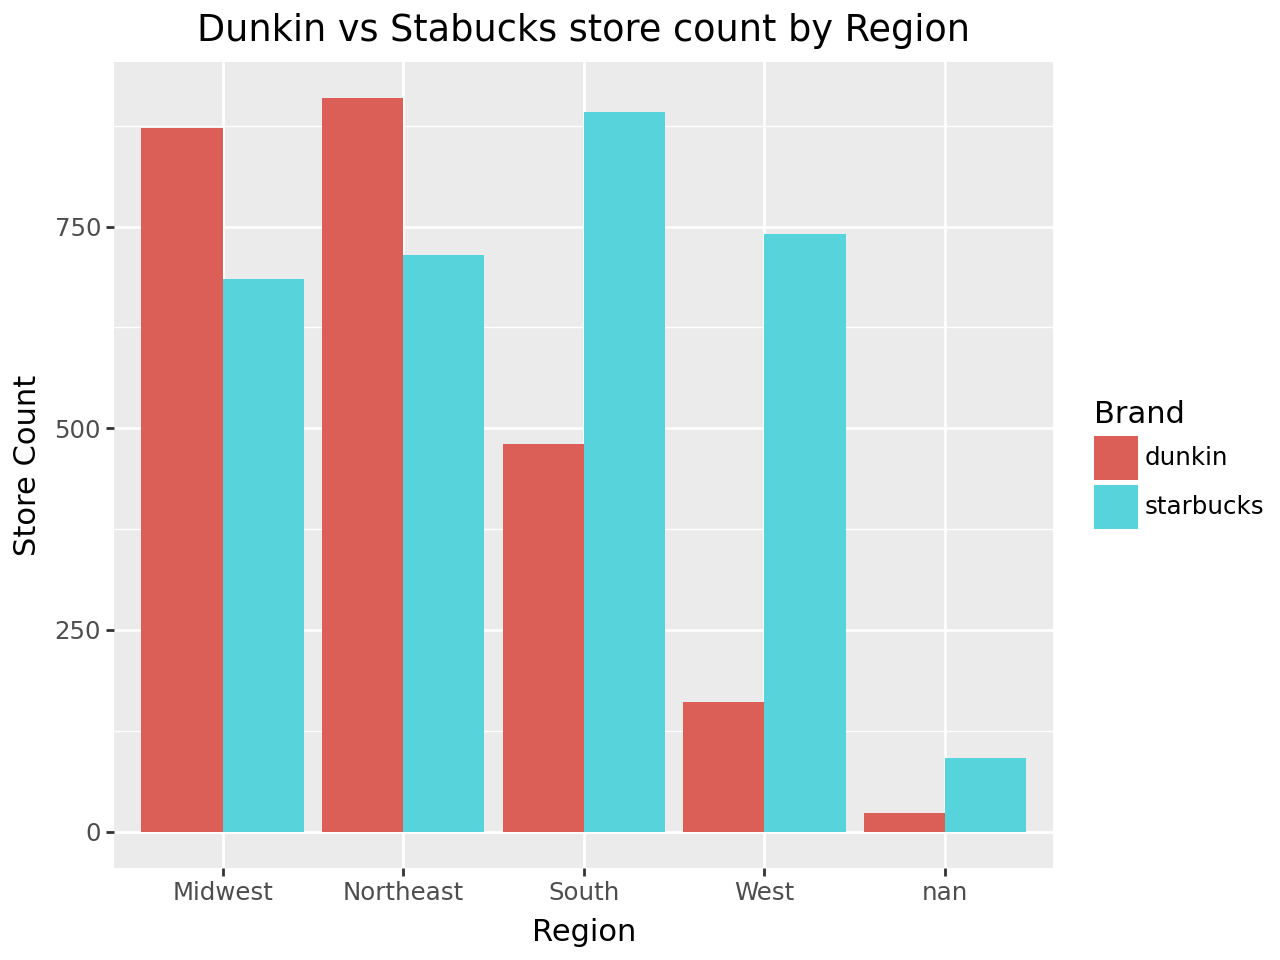

In [183]:
(ggplot(coffee_rev, aes(x='Region', y='count', fill = 'Brand'))
 + geom_bar(stat="identity", position="dodge") 
 + labs(x="Region", y="Store Count", 
        title="Dunkin vs Stabucks store count by Region", fill="Brand")
)

C:\Users\owenk\AppData\Local\Temp\ipykernel_19004\3313317119.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


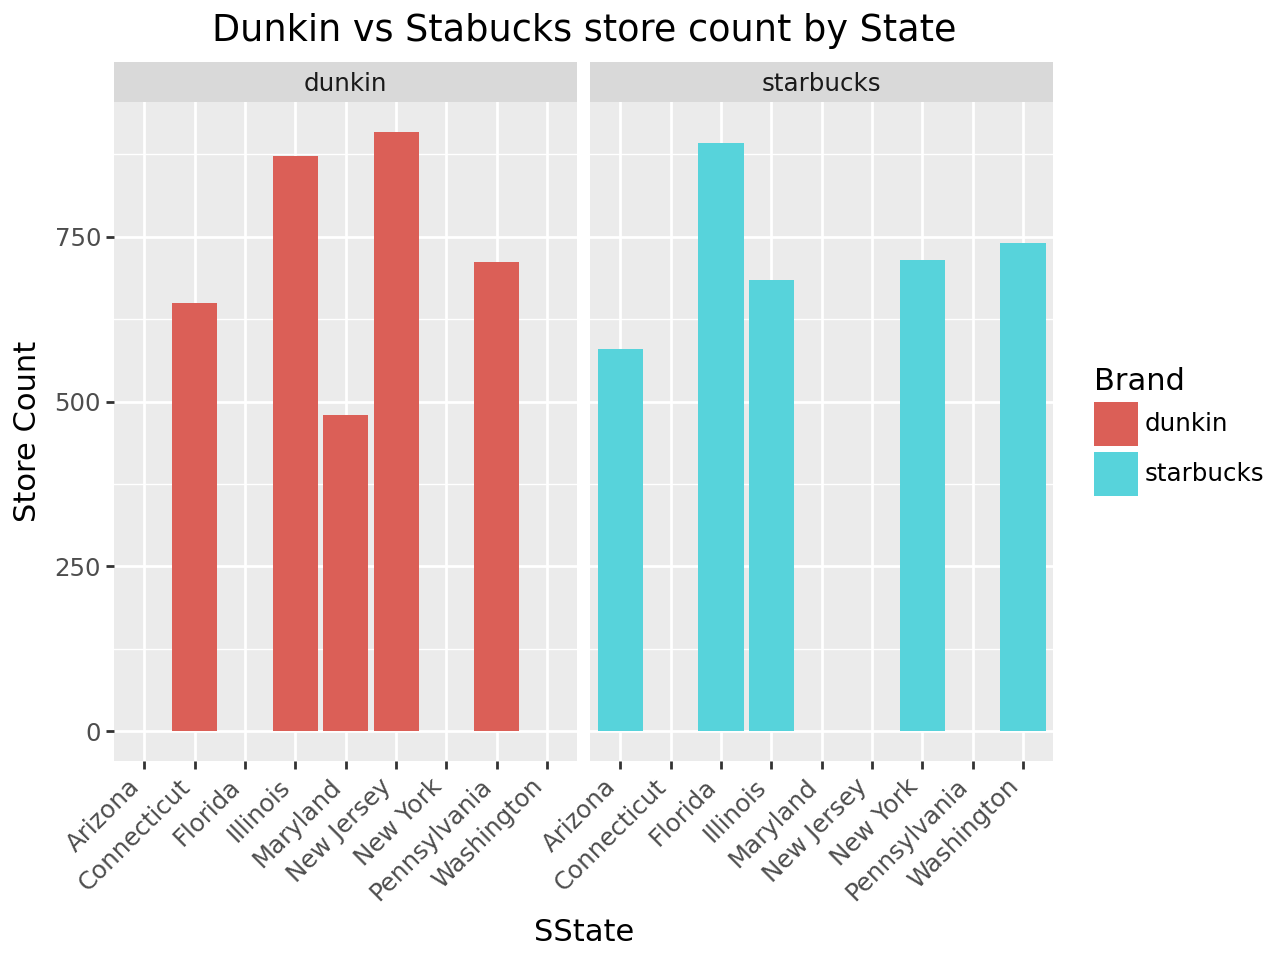

In [184]:
max_counts = coffee_rev.groupby(['State', 'Brand'], as_index=False)['count'].max()
sorted_counts = max_counts.sort_values(by='count', ascending=False)

top_10_states = (
    sorted_counts
    .groupby('Brand', as_index=False)  # Group by Brand for further operations
    .apply(lambda x: x.nlargest(5, 'count'))  # Get the top 10 for each Brand
    .reset_index(drop=True)  # Reset index for clean output
)

(ggplot(top_10_states, aes(x='State', y='count', fill = 'Brand'))
 + geom_bar(stat="identity", position="dodge") 
 + labs(x="SState", y="Store Count", 
        title="Dunkin vs Stabucks store count by State", fill="Brand")
 + facet_wrap("~ Brand")
 + theme(axis_text_x=element_text(angle=45, hjust=1))  # Rotate x labels

)

#### 8. Convert your code for Exercises 1-3 above to a function that takes a single argument: the URL. This function should:

Scrape the information on state names and corresponding number of store locations on the webpage specified (assume the page has a table in the same form and placement as the ones you scraped above)

Extract the name of the company from either the URL specified or the webpage (assume the URL will have the same format as the ones used above)

Return a clean, organized and tidy dataset. Find a page other than Starbucks and Dunkin’ Donuts to test this on to confirm that it works. It’s fine if this is not related to coffee.

In [185]:
def uni_extract(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find table and headers
    table = soup.find("table")
    headers = [th.get_text(strip=True) for th in table.find_all("th", class_="datatable-th")]
    states_list = [th.get_text(strip=True) for th in table.find_all("th")[len(headers):]]

    # Collect rows of data
    rows = []
    for i, tr in enumerate(table.find_all("tr")[1:]):
        cells = tr.find_all("td")
        row_data = {"State": states_list[i]}

        # Populate row data with header-keyed cell values
        for j, cell in enumerate(cells):
            cell_text = (cell.find("a") or cell).get_text(strip=True)
            row_data[headers[j + 1]] = cell_text
        
        rows.append(row_data)

    # Convert to DataFrame and reshape
    df = pd.DataFrame(rows)
    df_tidy = df.melt(id_vars="State", var_name="Year", value_name="Count")

    # Extract store name and year from the Year column: referenced from Chat gpt. Assigns first word in the header as the name of the store, based on the website format for Starbucks

    if "Store" not in df_tidy.columns:
            df_tidy["Store"] = df_tidy["Year"].apply(lambda x: x.split()[0] if "" in x else "Unknown Store")
    df_tidy["Year"] = df_tidy["Year"].str.extract(r"(\d{4})")[0] #extracts a 4 digit year from the year column using regular expression
    df_tidy = df_tidy.fillna('')
    return df_tidy

In [186]:
uni_extract("https://worldpopulationreview.com/state-rankings/dutch-bros-by-state")
# Dutch Bros not specified in table like in Starbucks and Dunkin Donuts
# Data is only for 2024, so year is also not specified in the same format

,State,Year,Count,Store
0,Oregon,,155,#
1,California,,149,#
2,Texas,,142,#
3,Arizona,,76,#
4,Washington,,66,#
5,Colorado,,44,#
6,Idaho,,37,#
7,Nevada,,30,#
8,Utah,,22,#
9,Oklahoma,,21,#
